In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#run1_df = pd.read_csv("DATA_FINAL/default_run1_vessels.csv")
#times = np.sort(run1_df["Time"].unique())
#time_set_1 = np.zeros(len(times), dtype=object)
#for i in range(len(times)):
#    time_set_1[i] = run1_df[run1_df["Time"] == times[i]]

In [85]:
def density_slices(
    time_set_df: object,     # data frame of consideration
    dy: float,               # width of slice
    N_slices: int,           # resulting number of slices
    N_times: int             # number of time iterations
    ):
    """Initialise needed arrays"""
    x_min = np.zeros((N_times, N_slices), dtype=object)
    x_max = np.zeros((N_times, N_slices), dtype=object)
    counts = np.zeros((N_times, N_slices))

    """Loop over all slices over the whole time"""
    for j in range(N_times):
        for i in range(N_slices):
            """Slice the MinY set"""
            slice_i_min = time_set_df[j][time_set_df[j]["MinY"]>=i*dy]
            slice_i_min = time_set_df[j][time_set_df[j]["MinY"]<(i+1)*dy]
            x_min[j,i] = slice_i_min[["MinX", "MinY", "MinZ"]].to_numpy()
            counts[j,i] = len(x_min[j,i])

            """Slice the MaxY set"""
            slice_i_max = time_set_df[j][time_set_df[j]["MaxY"]>=i*dy]
            slice_i_max = time_set_df[j][time_set_df[j]["MaxY"]<(i+1)*dy]
            x_max[j,i] = slice_i_max[["MaxX", "MaxY", "MaxZ"]].to_numpy()
            counts[j,i] += len(x_max[j,i])

    """ Output: List of pores within a given slice index, total count of pores within a slice """
    return x_min, x_max, counts


def density_plots(
    run_df: object,   # data frame of run
    run_name: str,    # name for image exporting
    dy: float,        #slice width
    slice_index: np.ndarray = [],    # Which slices
    time_index: np.ndarray = []      # which time intervals
):
    """ Gather the unique time points of simulation and sort data into which time snapshot """
    times = np.sort(run_df["Time"].unique())          # list of time points from smallest to largest
    time_set = np.zeros(len(times), dtype=object)     
    for i in range(len(times)):            
        time_set[i] = run_df[run_df["Time"] == times[i]]      # sorting data into time snapshots

    """ Initialise slice domain size, # slices, # time points for simulation """
    maxim = max(run_df["MinY"].max(), run_df["MaxY"].max())
    N_slices = int(maxim/dy)+1
    N_times = len(times)

    """ Generate the resulting pore densities at each slice """
    x_min, x_max, counts = density_slices(time_set, dy, N_slices, N_times)

    """ Ensure valid index range to loop over if not otherwise specified """
    if len(slice_index) == 0:
        slice_index = range(N_slices)
    if len(time_index) == 0:
        time_index = range(len(times))

    """ --------------------------------- Slice Plotting --------------------------------- """
    """ Initialise Plotting """
    fig, ax = plt.subplots(len(time_index), len(slice_index))

    """ Gather the maximum domain size of all data for consistent visuals """
    x_axis_min = min(run_df["MinX"].min(), run_df["MaxX"].min())
    x_axis_max = max(run_df["MinX"].max(), run_df["MaxX"].max())
    z_axis_min = min(run_df["MinZ"].min(), run_df["MaxZ"].min())
    z_axis_max = max(run_df["MinZ"].max(), run_df["MaxZ"].max())

    """ Generate scatter plots of each requested slice """
    for t in range(len(time_index)):
        for s in range(len(slice_index)):
            ax[t,s].scatter(x_min[time_index[t], slice_index[s]][:,0], x_min[time_index[t], slice_index[s]][:,2],
                            sizes = 1e-2+np.zeros_like(x_min[time_index[t], slice_index[s]][:,0]), color = "g")
            ax[t,s].scatter(x_max[time_index[t], slice_index[s]][:,0], x_max[time_index[t], slice_index[s]][:,2],
                            sizes = 1e-2+np.zeros_like(x_max[time_index[t], slice_index[s]][:,0]), color = "g")
            ax[t,s].set_xlim(0, x_axis_max)
            ax[t,s].set_ylim(0, z_axis_max)
            ax[t,s].xaxis.set_visible(False)  # Hide X-axis for clarity
            ax[t,s].set_yticks([])
            #ax[t,s].yaxis.set_visible(False)  # Hide Y-axis for clarity
        ax[t,0].set_ylabel(f"t={time_index[t]}")

    """ Gather the mean value for slices shown """
    y_mids = np.round((dy/2 + np.linspace(0, maxim, N_slices+1)[:-1])*1e6, 2)

    """ Gather and distribute the titles for each coloumn of plotting matrix """
    cols = [r"{} $\mu$m".format(y) for y in y_mids[slice_index]]
    for axis, col in zip(ax[0], cols):
         axis.set_title(col)

    """ Save figure and close it to prevent notebook overshowing """
    fig.supxlabel("position")
    #fig.supylabel("time")
    plt.tight_layout()
    fig.savefig(f"{run_name}_slices.png")
    plt.close(fig)

    """ --------------------------------- Density Plotting --------------------------------- """
    """ Gather the area of the domain """
    area = x_axis_max*1e3*z_axis_max*1e3   # Convert m to mm for area

    """ Plot the overall density through all slices through all time steps """
    gif,ay = plt.subplots()
    for m in range(len(times)):
        ay.plot(y_mids, counts[m,:]/area, label = times[m] )
    ay.legend()
    gif.savefig(f"{run_name}_density.png")
    plt.close(gif)

    """ Output: density as pores/mm^2 """
    return counts/area
        

In [84]:
""" Generate all data from all simulated runs and compute the average over run types """

runs = [ "default", "FastBranching", "SlowBranching", "HighAlpha", "LowAlpha", "HighChi", "LowChi",
         "HighEpsilon", "LowEpsilon", "HighNu", "LowNu", "WSS"]
run_no = 3 + 1   # +1 for average run later on

""" Parameter settings
dy: slice width
slice_index: np array with indexes of slicing set ~ maxim = 4e-4,  N_slices = maxim/dy
"""

dy = 1e-5
slice_index = np.array((0, -22,  -20, -18, -1))

variables = {}       
""" Loop over all runs of all run types
--- Outputs: saved Slice Plots as png, densitys of all slices in variables  """
for run_type in runs:
    variables[run_type] = [None]*run_no
    for run in range(run_no-1):
        df = pd.read_csv(f"DATA_FINAL/{run_type}_run{run+1}_vessels.csv")
        variables[run_type][run] = density_plots(df, f"{run_type}_{run+1}", dy, slice_index)
    variables[run_type][-1] = np.mean(variables[run_type][:-1], axis = 0)

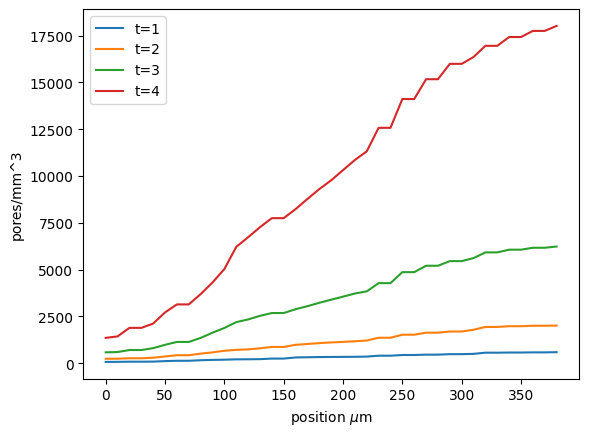

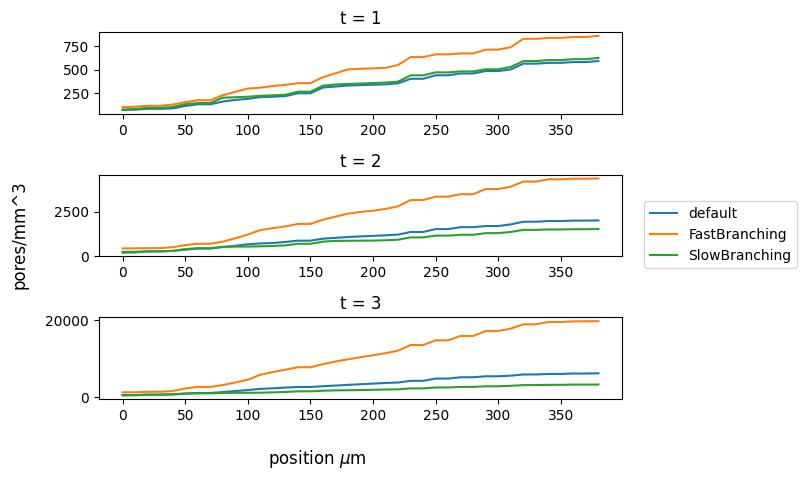

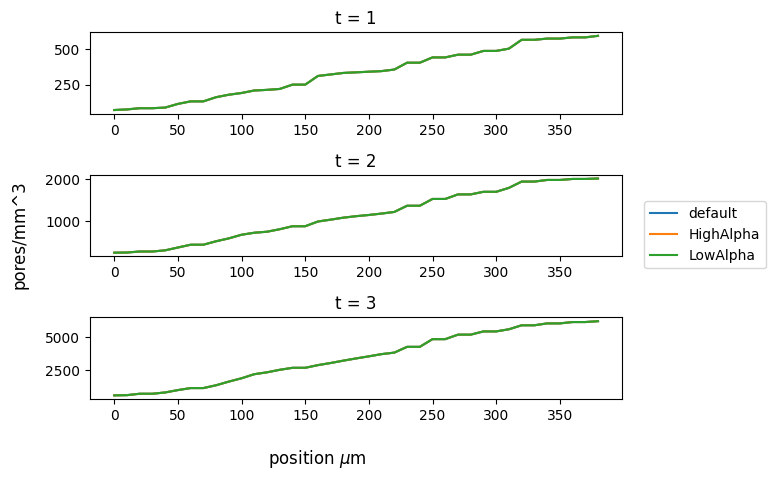

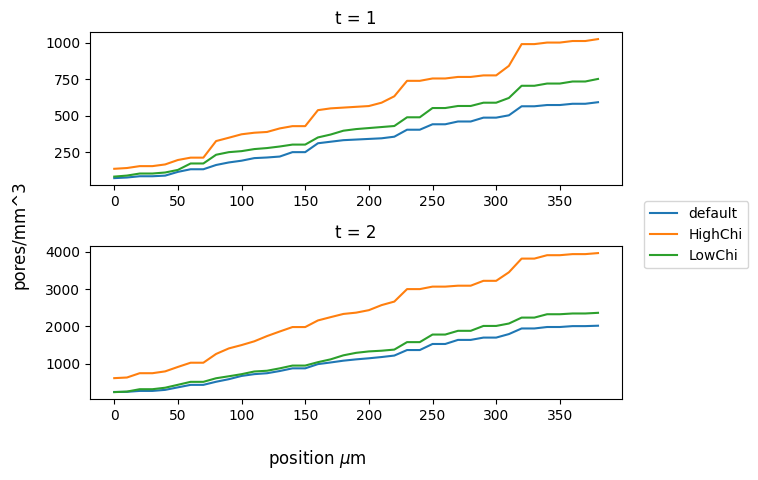

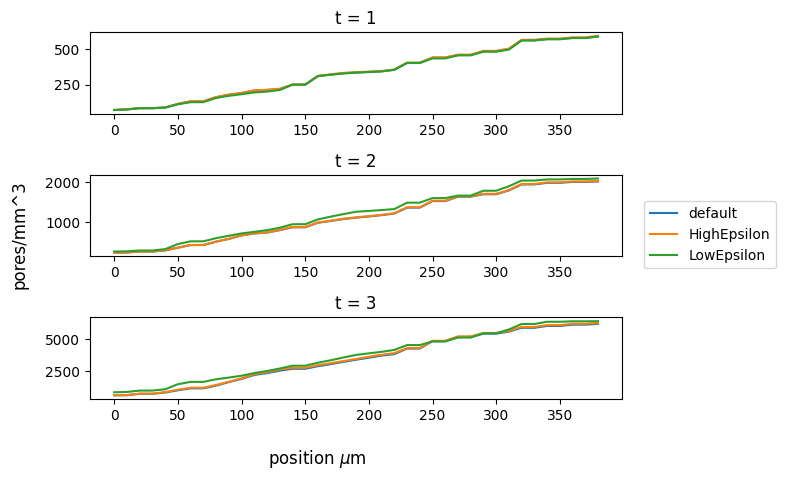

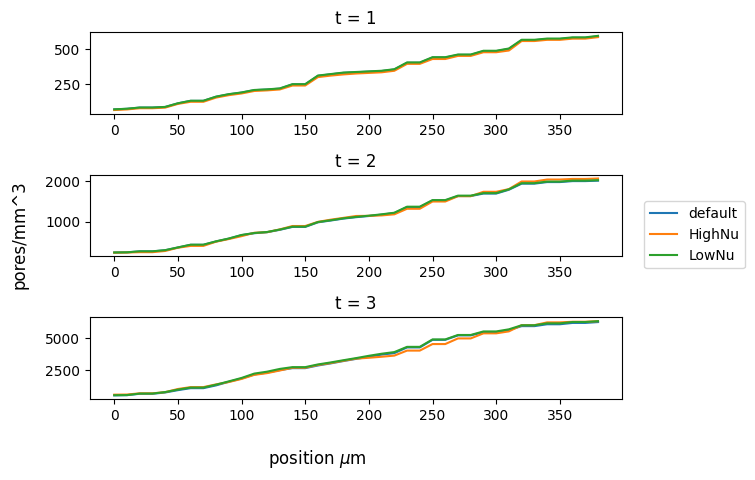

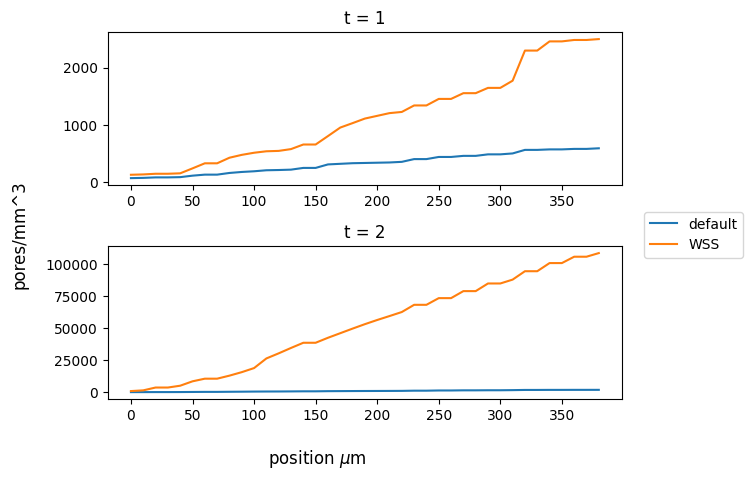

In [60]:
""" Compare Averages Of All Run Types For Each Time Run """
""" Time Plots: 
--- Compare each run type with default?
--- Final one with all?
"""

""" Break into different Run Types:
--- 1. Default
--- 2. Branching (Fast/Slow)
--- 3. Alpha (High/Low)
--- 4. Chi (High/Low)
--- 5. Epsilon (High/Low)
--- 6. Nu (High/Low)
--- 7. WSS (On)
"""

default = ["default"]
Branching = ["default", "FastBranching", "SlowBranching"]
Alpha = ["default", "HighAlpha", "LowAlpha"]
Chi = ["default", "HighChi", "LowChi"]
Epsilon = ["default", "HighEpsilon", "LowEpsilon"]
Nu = ["default", "HighNu", "LowNu"]
WSS = ["default", "WSS"]
cases = [default, Branching, Alpha, Chi, Epsilon, Nu, WSS]

""" Need more colours for plot """
Colours_no = len(runs)
cm = plt.get_cmap("gist_rainbow")

""" Axis Set up """
x_axis = np.linspace(0, dy*len(variables["default"][-1][0]), len(variables["default"][-1][0])+1)[:-1]*1e6

""" Cant Think of efficiency """
""" --- Default Plot --- """
fig, aa = plt.subplots()
for t in range(run_no):
    for run in default:
        aa.plot(x_axis, variables[run][-1][t], label = f"t={t+1}")
plt.ylabel("pores/mm^3")
plt.xlabel(r"position $\mu$m")
plt.legend()
plt.savefig("Default_density_over_time.png")

""" --- Branching Plot --- """
fig, ab = plt.subplots(run_no-1)
for t in range(run_no-1):
    for run in Branching:
        ab[t].plot(x_axis, variables[run][-1][t], label = f"{run}" if t==0 else "")
        ab[t].set_title(f"t = {t+1}")
fig.supylabel("pores/mm^3")
fig.supxlabel(r"position $\mu$m")
plt.tight_layout()
plt.figlegend(loc = "center left", bbox_to_anchor=(1,0.5))
plt.savefig("Branching_density_over_time.png", bbox_inches="tight")

""" --- Alpha Plot --- """
fig, ac = plt.subplots(run_no-1)
for t in range(run_no-1):
    for run in Alpha:
        ac[t].plot(x_axis, variables[run][-1][t], label = f"{run}" if t==0 else "")
        ac[t].set_title(f"t = {t+1}")
fig.supylabel("pores/mm^3")
fig.supxlabel(r"position $\mu$m")
plt.tight_layout()
plt.figlegend(loc = "center left", bbox_to_anchor=(1,0.5))
plt.savefig("Alpha_density_over_time.png", bbox_inches="tight")

""" --- Chi Plot --- """
fig, ad = plt.subplots(run_no-2)
for t in range(run_no-2):
    for run in Chi:
        ad[t].plot(x_axis, variables[run][-1][t], label = f"{run}" if t==0 else "")
        ad[t].set_title(f"t = {t+1}")
fig.supylabel("pores/mm^3")
fig.supxlabel(r"position $\mu$m")
plt.tight_layout()
plt.figlegend(loc = "center left", bbox_to_anchor=(1,0.5))
plt.savefig("Chi_density_over_time.png", bbox_inches="tight")

""" --- Epsilon Plot --- """
fig, ae = plt.subplots(run_no-1)
for t in range(run_no-1):
    for run in Epsilon:
        ae[t].plot(x_axis, variables[run][-1][t], label = f"{run}" if t==0 else "")
        ae[t].set_title(f"t = {t+1}")
fig.supylabel("pores/mm^3")
fig.supxlabel(r"position $\mu$m")
plt.tight_layout()
plt.figlegend(loc = "center left", bbox_to_anchor=(1,0.5))
plt.savefig("Epsilon_density_over_time.png", bbox_inches="tight")

""" --- Nu Plot --- """
fig, af = plt.subplots(run_no-1)
for t in range(run_no-1):
    for run in Nu:
        af[t].plot(x_axis, variables[run][-1][t], label = f"{run}" if t==0 else "")
        af[t].set_title(f"t = {t+1}")
fig.supylabel("pores/mm^3")
fig.supxlabel(r"position $\mu$m")
plt.tight_layout()
plt.figlegend(loc = "center left", bbox_to_anchor=(1,0.5))
plt.savefig("Nu_density_over_time.png", bbox_inches="tight")

""" --- WSS Plot --- """
fig, ag = plt.subplots(run_no-2)
for t in range(run_no-2):
    for run in WSS:
        ag[t].plot(x_axis, variables[run][-1][t], label = f"{run}" if t==0 else "")
        ag[t].set_title(f"t = {t+1}")
fig.supylabel("pores/mm^3")
fig.supxlabel(r"position $\mu$m")
plt.tight_layout()
plt.figlegend(loc = "center left", bbox_to_anchor=(1,0.5))
plt.savefig("WSS_density_over_time.png", bbox_inches="tight")

   #     for run_type in runs:
   #         #print(run_type)
   #         ax[t].plot(x_axis, variables[run_type][-1][t],label = f"{run_type}" if t==0 else "")
   #         plt.figlegend(loc = "center left", bbox_to_anchor=(1,0.5))